# Test on the canopy data 

In [1]:
from pivpy import io
from pivpy import graphics
import xarray as xr
import numpy as np

In [2]:
# one file 
data = io.load_vc7('../../tests/data/urban_canopy/B00001.vc7')

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120aac048>)

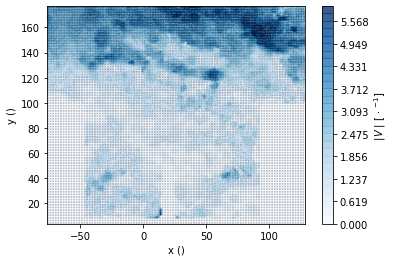

In [3]:
data.attrs['units'] = ['mm','mm','m/s','m/s']
graphics.quiver(data,arrScale=100)

In [4]:
data = io.load_directory('../../tests/data/urban_canopy/',basename='B*',ext='.vc7')

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x125d01cf8>)

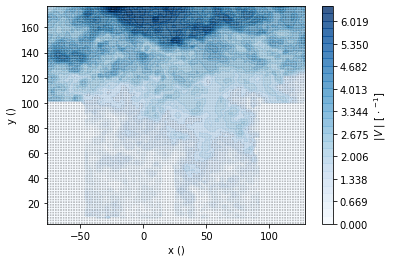

In [8]:
graphics.quiver(data.isel(t=-1),arrScale=100) # show last